# **The Effects of Automobile Dependency in the United States**
## Contributors: Nicholas Breymaier and Zachary Osborne
Nicholas UID: 117920871 <br>
Zachary UID: 117941609 <br>
<a href='https://github.com/nicholasbreymaier/nicholasbreymaier.github.io'> Source Code </a>

# Introduction
A place, ranging from a neighborhood-scale to nation-scale geographic area, is referred to as automobile dependent, or car dependent, when the only means by which residents are realistically capable of reaching necessities is by driving a personal automobile. By necessities we mean any locations necessary to live a successful life in modern society, such as institutions of education, jobs, and grocery stores.

This analysis will focus prinarily on automobile dependency in the United States, but data from other countries will be used for comparative purposes.

## The Importance of Automobile Dependency
Some of the information presented in this section is drawn directly from the datasets we analyze in this project, and will be cited as such. Please see the bibliography at the end of this document/website for sources.

## Relevance in the Field of Data Science
Coverage by the major media institutions in the United States fails to correlate with what Americans die from (!cite 1). Among other things, the need for major media institutions to "keep up" with the incessant and immediate news which is able to be transmitted via social media has lead to institutions (!cite) switching to more eyecatching topics to maintain viewership and therefore advertisement revenue. Relying on the media is therefore not an effective way to build public awareness about systemic problems.

Data Science offers a promising alternative medium of news coverage as opposed to televised reports transmitted by major media corporations and news transmitted via social media because it is significantly less prone to outlier bias. This project hopes to demonstrate that data science can be used to generate awareness about important yet overlooked societal issues by doing so with car dependency.

# Step 1: Data Collection
Thankfully, the US National Highway Traffic Safety Administration (NHTSA) keeps detailed data related to traffic fatalities, which serves as a good starting point for discussing the problem of car dependency.

https://www-fars.nhtsa.dot.gov/Main/index.aspx

In [171]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import matplotlib.pyplot as plt

In [172]:

# # Use the python requests library to extract the data from the website.
# web_extract = requests.get(
#     'https://www-fars.nhtsa.dot.gov/Main/index.aspx').text

# # Organise and make legible the extracted html using the BeautifulSoup library.
# web_extract = bs(web_extract)
# web_extract.prettify()

# loci = web_extract.find('table')

# # Extract the html tables into pandas dataframes. Tables 1–9 were
# # stylistic elements in the website.
# nhtsa_nat_stats = pd.read_html(str(loci))[10]

nhtsa_nat_stats = pd.read_feather('nhtsa_nat_stats.feather')
nhtsa_nat_stats.head()

,Unnamed: 0,2020,2019,2018,2017,2016,2015,2014,2013,2012,...,2003,2002,2001,2000,1999,1998,1997,1996,1995,1994
0,Motor Vehicle Traffic Crashes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fatal Crashes,35766.0,33487.0,33919.0,34560.0,34748.0,32538.0,30056.0,30202.0,31006.0,...,38477.0,38491.0,37862.0,37526.0,37140.0,37107.0,37324.0,37494.0,37241.0,36254.0
2,Traffic Crash Fatalities,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Vehicle Occupants,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Drivers,19519.0,17984.0,18321.0,18819.0,18717.0,17615.0,16470.0,16520.0,16838.0,...,23352.0,23625.0,22914.0,22914.0,22971.0,22654.0,22730.0,22572.0,22370.0,21596.0


# Step 2: Data Processing
The NHTSA crash fatality data we extracted is far from tidy, so we shall clean and organise it here. 

Firstly, this DataFrame holds features in its rows and observations in its columns. Obervations are, in this case, years. We therefore transpose the dataframe to make the rows observations and the columns features.

In [173]:
# We will want these to be the column labels after transposing the DataFrame.
nhtsa_nat_stats = nhtsa_nat_stats.set_index('Unnamed: 0')

# Transpose the DataFrame.
nhtsa_nat_stats = nhtsa_nat_stats.transpose()

# Rename index column to 'Year' and sort data chronologically.
nhtsa_nat_stats.columns.names = ['Year']
nhtsa_nat_stats = nhtsa_nat_stats.sort_index()

nhtsa_nat_stats.head()

Year,Motor Vehicle Traffic Crashes,Fatal Crashes,Traffic Crash Fatalities,Vehicle Occupants,Drivers,Passengers,Unknown,Sub Total1,Motorcyclists,Nonmotorists,...,Other National Statistics,Vehicle Miles Traveled (Billions),Resident Population (Thousands),Registered Vehicles (Thousands),Licensed Drivers (Thousands),National Rates: Fatalities,Fatalities per 100 Million Vehicle Miles Traveled,"Fatalities per 100,000 Population","Fatalities per 100,000 Registered Vehicles","Fatalities per 100,000 Licensed Drivers"
1994,NaN,36254.0,NaN,NaN,21596.0,10294.0,108.0,31998.0,2320.0,NaN,...,NaN,2358.0,260327.0,192497.0,175403.0,NaN,1.73,15.64,21.15,23.21
1995,NaN,37241.0,NaN,NaN,22370.0,10576.0,118.0,33064.0,2227.0,NaN,...,NaN,2423.0,262803.0,197065.0,176628.0,NaN,1.73,15.91,21.22,23.68
1996,NaN,37494.0,NaN,NaN,22572.0,10860.0,102.0,33534.0,2161.0,NaN,...,NaN,2484.0,265229.0,201631.0,179539.0,NaN,1.69,15.86,20.86,23.43
1997,NaN,37324.0,NaN,NaN,22730.0,10765.0,114.0,33609.0,2116.0,NaN,...,NaN,2552.0,267784.0,203568.0,182709.0,NaN,1.65,15.69,20.64,22.99
1998,NaN,37107.0,NaN,NaN,22654.0,10327.0,107.0,33088.0,2294.0,NaN,...,NaN,2628.0,270248.0,208076.0,184861.0,NaN,1.58,15.36,19.95,22.45


The original data table groups its features into various categories via extra, empty features which essentially function as "headers". This is a very messy way to do this, and furthermore having the categorization within the table is unnecessary. Here, we remove the unnecessary columns and rename the rest for clarity and to preserve information which would otherwise have been lost during the purging of the headers.

In [174]:
# Drop empty header columns.
columns_to_remove = [
    'Motor Vehicle Traffic Crashes', 
    'Traffic Crash Fatalities',
    'Vehicle Occupants', 
    'Nonmotorists',
    'Other National Statistics', 
    'National Rates: Fatalities'
]

nhtsa_nat_stats.drop(columns=columns_to_remove, inplace=True)

In [175]:
# Rename remaining columns for clarity 
nhtsa_nat_stats = nhtsa_nat_stats.rename(
    columns={
    'Drivers' : 'Driver Fatalities',
    'Passengers' : 'Passenger Fatalities',
    'Unknown' : 'Unknown Vehicle Occupant Fatalities',
    'Sub Total1' : 'Total Vehicle Occupant Fatalities',
    'Motorcyclists' : 'Motorcyclist Fatalities',
    'Pedestrians' : 'Pedestrian Fatalities',
    'Pedalcyclists' : 'Pedalcyclist Fatalities',
    'Other/ Unknown' : 'Other/Unknown Nonmotorist Fatalities',
    'Sub Total2' : 'Total Nonmotorist Fatalities',
    'Total*' : 'Total Fatalities'
    }
)

nhtsa_nat_stats.head()

Year,Fatal Crashes,Driver Fatalities,Passenger Fatalities,Unknown Vehicle Occupant Fatalities,Total Vehicle Occupant Fatalities,Motorcyclist Fatalities,Pedestrian Fatalities,Pedalcyclist Fatalities,Other/Unknown Nonmotorist Fatalities,Total Nonmotorist Fatalities,Total Fatalities,Vehicle Miles Traveled (Billions),Resident Population (Thousands),Registered Vehicles (Thousands),Licensed Drivers (Thousands),Fatalities per 100 Million Vehicle Miles Traveled,"Fatalities per 100,000 Population","Fatalities per 100,000 Registered Vehicles","Fatalities per 100,000 Licensed Drivers"
1994,36254.0,21596.0,10294.0,108.0,31998.0,2320.0,5489.0,802.0,107.0,6398.0,40716.0,2358.0,260327.0,192497.0,175403.0,1.73,15.64,21.15,23.21
1995,37241.0,22370.0,10576.0,118.0,33064.0,2227.0,5584.0,833.0,109.0,6526.0,41817.0,2423.0,262803.0,197065.0,176628.0,1.73,15.91,21.22,23.68
1996,37494.0,22572.0,10860.0,102.0,33534.0,2161.0,5449.0,765.0,154.0,6368.0,42065.0,2484.0,265229.0,201631.0,179539.0,1.69,15.86,20.86,23.43
1997,37324.0,22730.0,10765.0,114.0,33609.0,2116.0,5321.0,814.0,153.0,6288.0,42013.0,2552.0,267784.0,203568.0,182709.0,1.65,15.69,20.64,22.99
1998,37107.0,22654.0,10327.0,107.0,33088.0,2294.0,5228.0,760.0,131.0,6119.0,41501.0,2628.0,270248.0,208076.0,184861.0,1.58,15.36,19.95,22.45


Some of the units of measurements in the nhtsa national statistics data are poorly chosen, thus hindering interpretability. Specifically, the columns "Vehicle Miles Traveled", "Resident Population", "Registered Vehicles", and "Licensed Drivers" are all measured in thousands or billions yet also have column values in the thousands. This results in numbers such as "2,358 billion" and "260,327 thousand". While these aren't terribly hard to interpret, they do reduce ease of use and interpretation. Below, we resolve this issue by increasing the units of measurement in the aforementioned columns and accordingly scaling column values.

In [176]:
# Store new names in list for better readability/conciseness and because they
# will be used multiple times
new_names = [
    'Vehicle Miles Traveled (Trillions)',
    'Resident Population (Millions)',
    'Registered Vehicles (Millions)',
    'Licensed Drivers (Millions)'
]

nhtsa_nat_stats = nhtsa_nat_stats.rename(
    columns={
    'Vehicle Miles Traveled (Billions)' : new_names[0],
    'Resident Population (Thousands)' : new_names[1],
    'Registered Vehicles (Thousands)' : new_names[2],
    'Licensed Drivers (Thousands)' : new_names[3]
    }
)

nhtsa_nat_stats[new_names] = nhtsa_nat_stats[new_names] / 1000

nhtsa_nat_stats[new_names].head()

Year,Vehicle Miles Traveled (Trillions),Resident Population (Millions),Registered Vehicles (Millions),Licensed Drivers (Millions)
1994,2.358,260.327,192.497,175.403
1995,2.423,262.803,197.065,176.628
1996,2.484,265.229,201.631,179.539
1997,2.552,267.784,203.568,182.709
1998,2.628,270.248,208.076,184.861


Below, we display the final, tidied version of the NHTSA National Statistics data.

In [177]:
nhtsa_nat_stats.head()

Year,Fatal Crashes,Driver Fatalities,Passenger Fatalities,Unknown Vehicle Occupant Fatalities,Total Vehicle Occupant Fatalities,Motorcyclist Fatalities,Pedestrian Fatalities,Pedalcyclist Fatalities,Other/Unknown Nonmotorist Fatalities,Total Nonmotorist Fatalities,Total Fatalities,Vehicle Miles Traveled (Trillions),Resident Population (Millions),Registered Vehicles (Millions),Licensed Drivers (Millions),Fatalities per 100 Million Vehicle Miles Traveled,"Fatalities per 100,000 Population","Fatalities per 100,000 Registered Vehicles","Fatalities per 100,000 Licensed Drivers"
1994,36254.0,21596.0,10294.0,108.0,31998.0,2320.0,5489.0,802.0,107.0,6398.0,40716.0,2.358,260.327,192.497,175.403,1.73,15.64,21.15,23.21
1995,37241.0,22370.0,10576.0,118.0,33064.0,2227.0,5584.0,833.0,109.0,6526.0,41817.0,2.423,262.803,197.065,176.628,1.73,15.91,21.22,23.68
1996,37494.0,22572.0,10860.0,102.0,33534.0,2161.0,5449.0,765.0,154.0,6368.0,42065.0,2.484,265.229,201.631,179.539,1.69,15.86,20.86,23.43
1997,37324.0,22730.0,10765.0,114.0,33609.0,2116.0,5321.0,814.0,153.0,6288.0,42013.0,2.552,267.784,203.568,182.709,1.65,15.69,20.64,22.99
1998,37107.0,22654.0,10327.0,107.0,33088.0,2294.0,5228.0,760.0,131.0,6119.0,41501.0,2.628,270.248,208.076,184.861,1.58,15.36,19.95,22.45


# Step 3: Exploratory Analysis & Data Visualization

As a part of our exploration and analysis of the data, we will want to visualize it through graphs. To aid in this, we have defined a function for plotting columns of a dataframe against the indices/other columns of the same dataframe below:

In [178]:
def plot_cols(df, y_cols, title, xlabel=None, ylabel=None, x_col=None):
    """
    Plots the specified columns y_cols of the dataframe df against either the indices of
    the dataframe or optionally a specified column x_col. All plotted lines will be on
    the same graph, with a legend to differentiate them

    If not specified, xlabel will default to x_col/index name and ylabel will default to y_cols[0]
    """

    # y_cols is expected to be a type list, so if the user passes a single column name we
    # want to make sure to convert it to a list of a single item
    y_cols = [y_cols] if type(y_cols) == str else y_cols
    # as explained above, y columns will be graphed against the dataframe indices if no column
    # is specifed for the x-axis
    x = df.index if x_col == None else df[x_col]
    # setting to defaults, as defined above, if necessary
    xlabel = df.columns.name if xlabel == None else xlabel
    ylabel = y_cols[0] if ylabel == None else ylabel

    # plots a line for each column
    for y_col in y_cols:
        plt.plot(x, df[y_col], label=y_col)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # ensuring the x tick labels are not overlapping
    plt.xticks(range(0, len(x), int(len(x)/5)))
    plt.legend()
    plt.show()

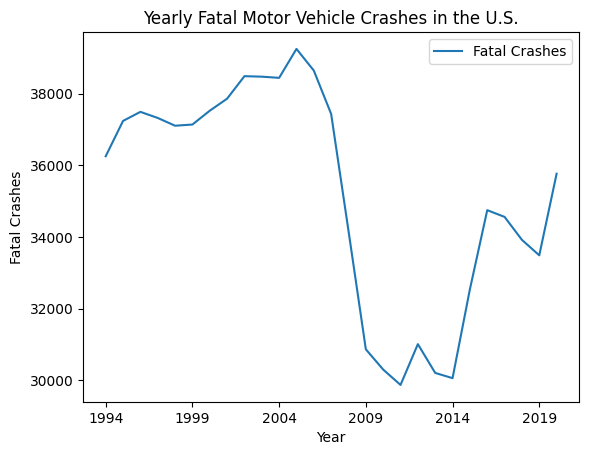

In [179]:
plot_cols(nhtsa_nat_stats, 'Fatal Crashes', 'Yearly Fatal Motor Vehicle Crashes in the U.S.')

# Step 4: Modeling and Further Analysis with Machine Learning and Statistics

# Step 5: Data Interpretation and Insight

# Further Information for the Inquisitive Reader

There are many advocates and advocacy groups, from local international, fighting to spread awareness about this issue and push for solutions to be implemented. Here a few are listed, as well as more general sources wherein the details of car dependency are discussed:
> * <a href='https://en.wikipedia.org/wiki/Car_dependency'>Wikipedia</a> is always a good starting point.
> * <a href='https://www.planetizen.com/definition/automobile-dependency'>Planetizen</a> and <a href='https://www.vtpi.org/tdm/tdm100.htm'>Victorya Transport Poliy Institute</a> both have very good articles defining and detailing some common aspects of car dependency.
> * <a href='https://www.youtube.com/@NotJustBikes/featured'>Not Just Bikes</a>, courtesy of Jason Slaughter, became most popular 'urban planning' channel on YouTube as of 2022. Not Just Bikes explores Dutch urban design and transportation engineering with a focus on comparing it to American and Canadian development. Car dependency is a central topic throughout these videos.
> * <a href='strongtowns.org'>Strong Towns</a> is an American advocacy organisation focused on local governance, city finances, and urban development. Its founder, Charles Marohn, served as a professional traffic engineer, and advocates for reduced car dependency in tandem with zoning reform and road design reform in the US.

# Bibliography
https://ourworldindata.org/does-the-news-reflect-what-we-die-from 1
https://www-fars.nhtsa.dot.gov/Main/index.aspx \\ 2
https://nepis.epa.gov/Exe/ZyPDF.cgi?Dockey=P1013L1O.pdf 3